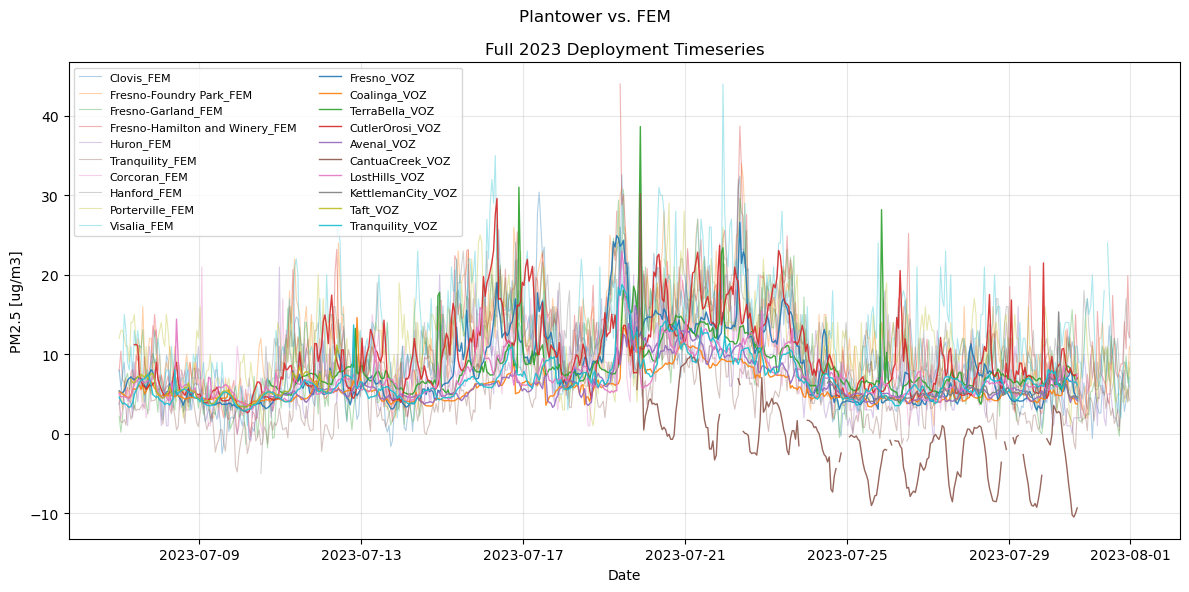

In [ ]:
#Run this code to create timeseries of voz plantowers and reference sites
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os

sys.path.append(os.path.abspath(".."))
from data_tools import handle_datetime
import data_tools.deployment_sets as sets

def create_vozdatetime_column(voz_file):
    vozdf = pd.read_csv(voz_file, usecols = ['date_time','PM_calibrated_ClarityRemake'])
    vozdf['date_time'] = pd.to_datetime(vozdf['date_time'])
    vozdf.set_index('date_time',inplace=True)
    return vozdf

def rename_pm_column(voz_file, vozdf):
    site = os.path.basename(voz_file)[8:].split('_', 1)[0]
    vozdf = vozdf.rename(columns={'PM_calibrated_ClarityRemake': f'{site}_VOZ'})
    return vozdf

def process_datetime(ref_site_df):
    ref_site_df = handle_datetime.create_utc_for_CARB(ref_site_df)
    ref_site_df = handle_datetime.utc_to_CA(ref_site_df)
    ref_site_df = (ref_site_df.drop(columns=['date', 'start_hour']))
    return ref_site_df

# Define file names and locations for reference and voz monitors
vozprefix = "../reference_files/2023PlantowerDataCalibrated/"
vozsuffix = "_mod_calibrated.csv"
voz_site_names = sets.files_2023()

ref_file = "../reference_files/PM25HR_PICKDATA_2023-12-31-AllReferences.csv"
ref_all = pd.read_csv(ref_file, usecols=['site', 'date', 'start_hour', 'value'])
ref_IDs = sets.CARB_pm25_IDs()

voz_file_names = []
for site in voz_site_names:
    voz_file_names.append(rf"{vozprefix}{site}{vozsuffix}")

timeseries = None
for site_name, site_id in ref_IDs.items():
    sub = ref_all.loc[ref_all['site'] == site_id, ['date', 'start_hour', 'value']].copy()
    if sub.empty:
        continue
    sub = process_datetime(sub)
    sub = sub.rename(columns={'value': f'{site_name}_FEM'})

    if timeseries is None:
        timeseries = sub
    else:
        timeseries = timeseries.join(sub, how='left')  # or how='outer' for union of timestamps

# VOZ loop unchanged, just safer initialization
for file in voz_file_names:
    vozdf = rename_pm_column(file, create_vozdatetime_column(file))
    if timeseries is None:
        timeseries = vozdf
    else:
        timeseries = timeseries.join(vozdf, how='left')

start_date = pd.to_datetime("2023-07-07")
end_date = pd.to_datetime("2023-08-01")

timeseries_filtered = timeseries[(timeseries.index >= start_date) & (timeseries.index <= end_date)]

df = timeseries_filtered.dropna(how='all', axis=1)

plt.figure(figsize=(12,6))
for col in df.columns:
    name=col
    if(name.endswith('_FEM')):
        alpha = 0.35
        lw = 0.8
        z = 1
    else:
        alpha = 0.9
        lw = 1
        z = 2
    plt.plot(df.index, df[col], label=name, linewidth=lw, alpha = alpha, zorder = z)
plt.legend(ncol=2, fontsize=8)
plt.title("Full 2023 Deployment Timeseries")
plt.suptitle("Plantower vs. FEM")
plt.xlabel("Date")
plt.ylabel("PM2.5 [ug/m3]")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(rf"./FullTimeseries.jpg", format='jpg', dpi=300)
plt.show()
